In [1]:
from pathlib import Path
from sqlalchemy import create_engine, text
from tqdm import tqdm
from datetime import datetime, date, timedelta
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from xgboost import XGBClassifier, plot_importance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys

In [2]:
ROOT_DIR = Path.cwd().parent
if str(ROOT_DIR) not in sys.path:
    sys.path.append(str(ROOT_DIR))

pd.set_option('display.max_columns', None)

In [3]:
from config import DB_URI
from sklearn.metrics import (
    roc_curve, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay
)
from sklearn.calibration import calibration_curve

In [4]:
engine = create_engine(DB_URI)
connection = engine.connect()

In [6]:
query_brief = f"""
    SELECT 
        id,
        probability,
        CASE 
            WHEN business_status IS NULL THEN 0
            WHEN business_status = 'Investigation' THEN 1
            ELSE NULL
        END AS business_status_numeric,
        created_at,
        identifier,
        data
    FROM incidents
    WHERE created_at >= '2025-05-07' 
    ORDER BY id
    LIMIT 50
"""

In [6]:
jet_query = f"""
    SELECT 
    id,
    probability,
    data->>'identifier' AS identifier,
    CASE 
        WHEN business_status IS NULL THEN 0
        WHEN business_status = 'Investigation' THEN 1
        ELSE NULL
    END AS business_status_numeric,
    created_at
FROM incidents
WHERE 
    (data->>'identifier' LIKE 'S.2%') AND
    (created_at >= '2025-04-16') AND 
    (created_at <= '2025-04-27')
ORDER BY id;
"""

In [7]:
from sqlalchemy import text

In [8]:
jet_df = pd.read_sql_query(
    text(jet_query),
    con=connection
)

In [10]:
jet_df

,id,probability,identifier,business_status_numeric,created_at
0,297074,3.0,S.216183,0,2025-04-16 10:30:09.050315
1,297078,12.0,S.257968,0,2025-04-16 10:31:20.578164
2,297079,8.0,S.227163,0,2025-04-16 10:31:50.216063
3,297082,30.0,S.241887,0,2025-04-16 10:32:35.026157
4,297093,34.0,S.241761,0,2025-04-16 10:34:52.191133
...,...,...,...,...,...
23783,481210,0.0,S.252885,0,2025-04-26 23:54:44.555797
23784,481211,0.0,S.253321,0,2025-04-26 23:54:47.360662
23785,481213,0.0,S.253142,0,2025-04-26 23:54:55.530120
23786,481214,0.0,S.253586,0,2025-04-26 23:54:58.049944


In [7]:
brief_df = pd.read_sql_query(query_brief, connection)

In [8]:
brief_df

,id,probability,business_status_numeric,created_at,identifier,data
0,662405,0,0,2025-05-07 00:00:03.605727,S.121021,"{'alarm_id': '681aa282c30c1f856e1dbe7c', 'iden..."
1,662406,1,0,2025-05-07 00:00:06.331320,S.023133,"{'alarm_id': '681aa2858907a1b93723b48e', 'iden..."
2,662407,0,0,2025-05-07 00:00:12.585057,S.011727,"{'alarm_id': '681aa28be543d45ec1570aa1', 'iden..."
3,662408,1,0,2025-05-07 00:00:13.181494,S.471006,"{'alarm_id': '681aa28b091089a0913ec1ba', 'iden..."
4,662409,8,0,2025-05-07 00:00:13.664841,S.448837,"{'alarm_id': '681aa28c2b21aa8993ddcf88', 'iden..."
5,662410,7,0,2025-05-07 00:00:17.825445,S.464599,"{'alarm_id': '681aa290052b637deb067e98', 'iden..."
6,662411,30,0,2025-05-07 00:00:18.257948,S.464744,"{'alarm_id': '681aa290ec5fc157e97d0714', 'iden..."
7,662412,0,0,2025-05-07 00:00:19.756067,S.160572,"{'alarm_id': '681aa292870cec94c8604ccd', 'iden..."
8,662413,0,0,2025-05-07 00:00:21.016859,S.145232,"{'alarm_id': '681aa293f35130ac254db301', 'iden..."
9,662414,2,0,2025-05-07 00:00:22.332970,S.154107,"{'alarm_id': '681aa2956017386b6a8ba378', 'iden..."


In [10]:
brief_df.iloc[0].data

{'alarm_id': '681aa282c30c1f856e1dbe7c',
 'identifier': 'S.121021',
 'alarm_type': 'stealing',
 'businessStatus': None,
 'businessSubStatus': None,
 'createDateTimeUtc': '2025-05-07T00:00:02.2111409Z',
 'operatorChoiceTime': '0001-01-01T00:00:00',
 'lastOrderStart': '2025-05-06T16:19:33.897Z',
 'lastOrderEnd': '2025-05-06T16:59:11.225Z',
 'endOrderLocation': {'lat': 55.77941131591797,
  'lng': 38.67634963989258,
  'time': '2025-05-06T16:59:11.225Z',
  'alt': 0.0,
  'raw_lat': 0.0,
  'raw_lng': 0.0,
  'rssi': 0.0,
  'locked': False,
  'is_online': False,
  'main_battery_percent': 0.0,
  'main_battery_voltage': 0.0,
  'main_battery_amperage': 0.0,
  'main_battery_temperature': 0.0,
  'second_battery_percent': 0.0,
  'second_battery_voltage': 0.0,
  'second_battery_amperage': 0.0,
  'second_battery_temperature': 0.0,
  'tracker_battery_percent': 0.0,
  'tracker_battery_voltage': 0.0,
  'temperature': 0.0,
  'speed_limit': 0.0,
  'confirmed_current_speed': None,
  'current_speed': 0.0,
  '

In [14]:
connection.rollback()


In [299]:
ex.loc[0].data

{'alarm_id': '680a2aec150616e1fd1869fe',
 'identifier': 'S.266608',
 'alarm_type': 'stealing',
 'businessStatus': None,
 'businessSubStatus': None,
 'createDateTimeUtc': '2025-04-24T12:13:32.6900924Z',
 'operatorChoiceTime': '0001-01-01T00:00:00',
 'lastOrderStart': '2025-04-24T11:44:08.007Z',
 'lastOrderEnd': '2025-04-24T11:49:28.349Z',
 'endOrderLocation': {'lat': 50.065664,
  'lng': 72.981359,
  'time': '2025-04-24T11:49:28.349Z',
  'alt': 0.0,
  'raw_lat': 0.0,
  'raw_lng': 0.0,
  'rssi': 0.0,
  'locked': False,
  'is_online': False,
  'main_battery_percent': 0.0,
  'main_battery_voltage': 0.0,
  'main_battery_amperage': 0.0,
  'main_battery_temperature': 0.0,
  'second_battery_percent': 0.0,
  'second_battery_voltage': 0.0,
  'second_battery_amperage': 0.0,
  'second_battery_temperature': 0.0,
  'tracker_battery_percent': 0.0,
  'tracker_battery_voltage': 0.0,
  'temperature': 0.0,
  'speed_limit': 0.0,
  'confirmed_current_speed': None,
  'current_speed': 0.0,
  'satellites': 0},

In [ ]:
'identifier': 'S.266608',

In [ ]:
df_brief = pd.read_sql_query(query_brief, connection)

In [ ]:
df_brief

In [305]:
# df_brief["prediction"] = (df_brief["probability"] > 50).astype(int)


In [13]:
df_brief[(df_brief["probability"] <= 1)].shape

(15920, 4)

In [308]:
df_brief.shape

(28482, 5)

In [285]:
mask = (
    (df_brief["probability"] <= 1) &
    (df_brief["business_status_numeric"] == 1) 
    # & df_brief["id"].astype(str).str.startswith("2")
)

result = df_brief.loc[mask, ["id", "probability", "created_at"]].reset_index()

In [272]:
pd.set_option('display.max_rows', None)

In [286]:
result

,index,id,probability,created_at
0,884,297956,1.0,2025-04-16 11:59:44.868819
1,1466,298538,1.0,2025-04-16 12:43:32.870633
2,1731,298803,1.0,2025-04-16 13:04:11.485634
3,2036,299108,1.0,2025-04-16 13:26:58.323520
4,3730,300802,1.0,2025-04-16 15:31:47.203703
5,6367,303439,1.0,2025-04-16 18:20:40.153822
6,8080,305152,0.0,2025-04-16 20:19:48.094707
7,8421,305493,0.0,2025-04-16 20:46:28.520973
8,8944,306016,0.0,2025-04-16 21:28:46.654306
9,9150,306222,1.0,2025-04-16 21:46:02.548804


In [275]:
df_brief.shape

(157887, 5)

# New metrics

In [62]:
y_true = df_brief["business_status_numeric"].fillna(0).astype(int).tolist()
y_pred = df_brief["prediction"].fillna(0).astype(int).tolist()


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96    114273
           1       0.40      0.57      0.47      6624

    accuracy                           0.93    120897
   macro avg       0.68      0.76      0.71    120897
weighted avg       0.94      0.93      0.93    120897



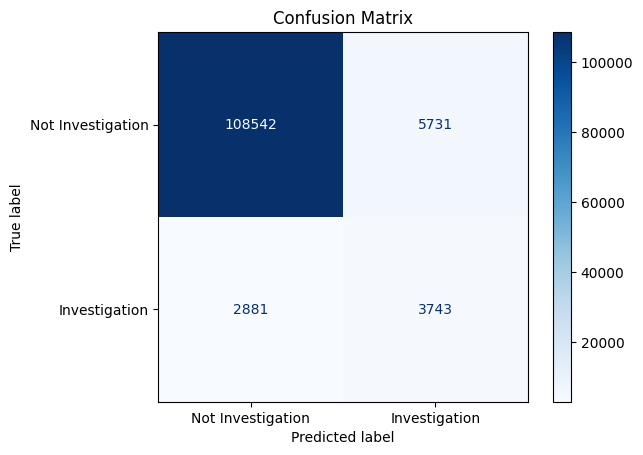

In [77]:
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, zero_division=0))

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Investigation", "Investigation"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [104]:
accuracy = accuracy_score(y_true, y_pred)
precision_0, precision_1 = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_0, recall_1 = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()


In [103]:
print("\n🔍 Detailed Metrics:")
print(f"Accuracy       : {accuracy:.4f}")
print(f"Precision (0)  : {precision_0:.4f}")
print(f"Precision (1)  : {precision_1:.4f}")
print(f"Recall (0)     : {recall_0:.4f}")
print(f"Recall (1)     : {recall_1:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"ROC AUC        : {roc_auc:.4f}" if roc_auc is not None else "ROC AUC        : Not computable (only one class present)")
print(f"Support (total): {len(y_true)}")



🔍 Detailed Metrics:
Accuracy       : 0.9288
Precision (0)  : 0.9741
Precision (1)  : 0.3951
Recall (0)     : 0.9498
Recall (1)     : 0.5651
F1 Score       : 0.4650
ROC AUC        : 0.7575
Support (total): 120897


In [82]:
tn, fp, fn, tp

(108542, 5731, 2881, 3743)

In [130]:
df_brief["date"] = pd.to_datetime(df_brief["created_at"]).dt.date


In [131]:
df_brief["prediction"] = (df_brief["probability"] > threshold).astype(int)
df_brief["date"] = pd.to_datetime(df_brief["created_at"]).dt.date

metrics_list = []
for date, group in df_brief.groupby("date"):
    y_true = group["business_status_numeric"]
    y_pred = group["prediction"]
    
    accuracy = accuracy_score(y_true, y_pred)
    precision_0, precision_1 = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_0, recall_1 = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred) if len(y_true.unique()) > 1 else None
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    metrics_list.append({
        "date": date,
        "accuracy": accuracy,
        "precision_0": precision_0,
        "precision_1": precision_1,
        "recall_0": recall_0,
        "recall_1": recall_1,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
    })

df_metrics = pd.DataFrame(metrics_list)

In [132]:
df_metrics

,date,accuracy,precision_0,precision_1,recall_0,recall_1,f1_score,roc_auc,tn,fp,fn,tp
0,2025-04-16,0.928393,0.971960,0.423749,0.951308,0.566096,0.484687,0.758702,9671,495,279,364
1,2025-04-17,0.920536,0.971703,0.338201,0.943537,0.512224,0.407407,0.727880,14388,861,419,440
2,2025-04-18,0.926060,0.980466,0.292989,0.941646,0.563121,0.385437,0.752383,15459,958,308,397
3,2025-04-19,0.931261,0.977764,0.403213,0.948990,0.614936,0.487061,0.781963,14511,780,330,527
4,2025-04-20,0.920262,0.967938,0.443503,0.945633,0.580407,0.502802,0.763020,13706,788,454,628
5,2025-04-21,0.928085,0.973186,0.409962,0.949870,0.570971,0.477252,0.760420,14590,770,402,535
6,2025-04-22,0.937101,0.973022,0.458594,0.959905,0.560649,0.504512,0.760277,16591,693,460,587
7,2025-04-23,0.936450,0.976108,0.402766,0.956511,0.556086,0.467168,0.756298,15198,691,372,466


In [153]:
def find_best_threshold(df, metric_name="f1", thresholds=np.arange(1, 100, 3)):
    best_threshold = None
    best_metric_value = -np.inf
    best_y_true, best_y_pred = None, None

    for threshold in thresholds:
        df["prediction"] = (df["probability"] > threshold).astype(int)
        y_true = df["business_status_numeric"]
        y_pred = df["prediction"]

        try:
            accuracy = accuracy_score(y_true, y_pred)
            precision_0, precision_1 = precision_score(y_true, y_pred, average=None, zero_division=0)
            recall_0, recall_1 = recall_score(y_true, y_pred, average=None)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            roc_auc = roc_auc_score(y_true, y_pred) if len(np.unique(y_true)) > 1 else 0.0

            metrics = {
                "accuracy": accuracy,
                "precision_0": precision_0,
                "precision_1": precision_1,
                "recall_0": recall_0,
                "recall_1": recall_1,
                "f1": f1,
                "roc_auc": roc_auc
            }

            score = metrics[metric_name]

            if score > best_metric_value:
                best_metric_value = score
                best_threshold = threshold
                best_y_true, best_y_pred = y_true.copy(), y_pred.copy()

        except Exception:
            continue

    print(f"\nЛучший threshold = {best_threshold} по метрике '{metric_name}' = {best_metric_value:.4f}\n")

    print("Classification Report:")
    print(classification_report(best_y_true, best_y_pred, zero_division=0))

    cm = confusion_matrix(best_y_true, best_y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Investigation", "Investigation"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    return best_threshold, best_metric_value


### Облегчаем задачу на 78% операторам, с погрешностью в 89% по классу 1 (кражи) 


Лучший threshold = 13 по метрике 'roc_auc' = 0.8564

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90    120150
           1       0.23      0.89      0.36      6968

    accuracy                           0.83    127118
   macro avg       0.61      0.86      0.63    127118
weighted avg       0.95      0.83      0.87    127118



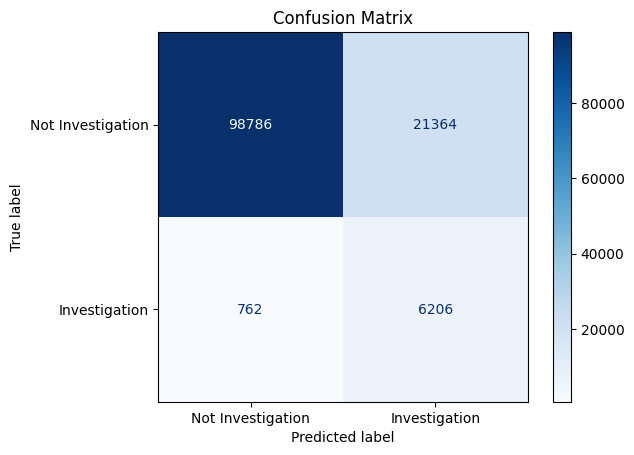

(13, 0.8564159348269695)

In [157]:
find_best_threshold(df_brief, metric_name="roc_auc")



Лучший threshold = 49 по метрике 'f1' = 0.4646

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96    120150
           1       0.39      0.58      0.46      6968

    accuracy                           0.93    127118
   macro avg       0.68      0.76      0.71    127118
weighted avg       0.94      0.93      0.93    127118



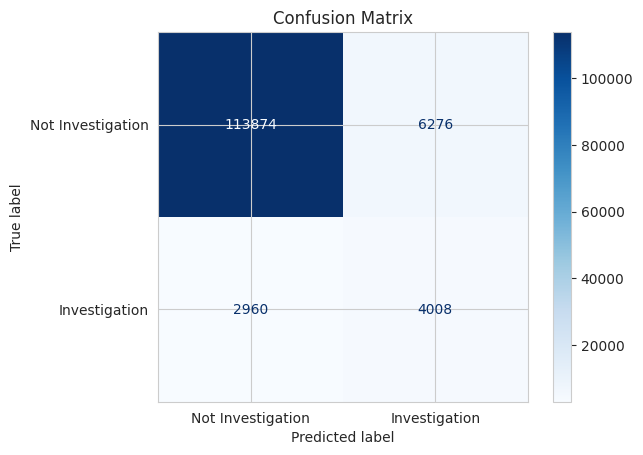

(49, 0.4646417806631115)

In [223]:
find_best_threshold(df_brief, metric_name="f1")



Лучший threshold = 79 по метрике 'accuracy' = 0.9488

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    120150
           1       0.59      0.23      0.33      6968

    accuracy                           0.95    127118
   macro avg       0.77      0.61      0.65    127118
weighted avg       0.94      0.95      0.94    127118



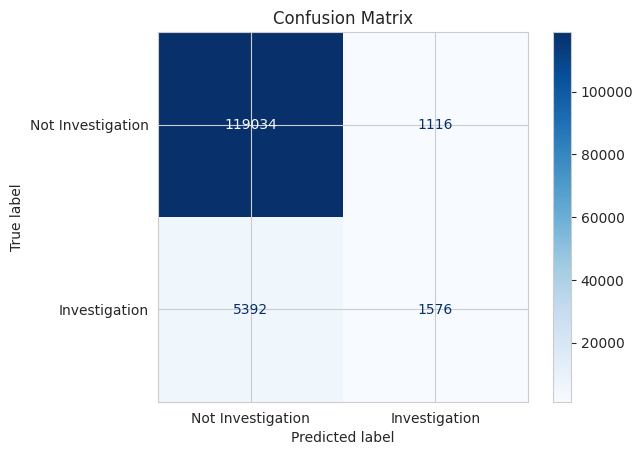

(79, 0.9488034739376013)

In [224]:
find_best_threshold(df_brief, metric_name="accuracy")


### Облегчаем задачу на 56% операторам, с погрешностью в 99% по классу 1 (кражи) = максимально не даем украсть самокаты


Лучший threshold = 1 по метрике 'recall_1' = 0.9821

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.59      0.74    120150
           1       0.12      0.98      0.22      6968

    accuracy                           0.61    127118
   macro avg       0.56      0.78      0.48    127118
weighted avg       0.95      0.61      0.71    127118



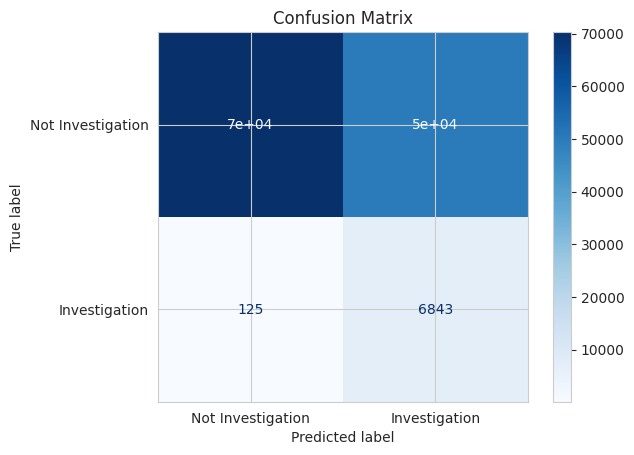

(1, 0.982060849598163)

In [225]:
find_best_threshold(df_brief, metric_name="recall_1")


# find_best_two_thresholds

In [219]:
def find_best_two_thresholds(
    df,
    metric_name="f1",
    thresholds=np.arange(0, 1.01, 0.05)
):
    """
    Ищет оптимальные нижний и верхний пороги по одной выбранной метрике,
    а затем для лучшей пары порогов рассчитывает полный отчет по всем метрикам.

    Параметры:
    ----------
    df : pandas.DataFrame
        Колонки: "probability", "business_status_numeric" (0/1).
    metric_name : str
        Метрика для оптимизации: "accuracy", "f1", "roc_auc",
        "precision_0", "precision_1", "recall_0", "recall_1".
    thresholds : iterable
        Значения порогов от 0 до 1.

    Возвращает:
    -----------
    best_low_threshold, best_high_threshold, best_metric_value, coverage
    """
    y = df["business_status_numeric"].values
    p = df["probability"].values

    best_low, best_high = None, None
    best_score = -np.inf
    best_coverage = 0.0

    # Шаг 1: только выбранная метрика
    for low_t in thresholds:
        for high_t in thresholds:
            if high_t <= low_t:
                continue

            # Предсказания: 0, 1 или -1
            preds = np.full_like(p, fill_value=-1, dtype=int)
            preds[p <= low_t] = 0
            preds[p >= high_t] = 1

            mask_conf = (preds != -1)
            if mask_conf.sum() == 0:
                continue

            y_true_conf = y[mask_conf]
            y_pred_conf = preds[mask_conf]

            # Считаем только целевую метрику
            try:
                if metric_name == "accuracy":
                    score = accuracy_score(y_true_conf, y_pred_conf)
                elif metric_name == "f1":
                    score = f1_score(y_true_conf, y_pred_conf, zero_division=0)
                elif metric_name == "roc_auc":
                    score = roc_auc_score(y_true_conf, y_pred_conf) \
                        if len(np.unique(y_true_conf)) > 1 else 0.0
                elif metric_name.startswith("precision_"):
                    label = int(metric_name.split("_")[1])
                    score = precision_score(y_true_conf, y_pred_conf,
                                             labels=[label], pos_label=label,
                                             zero_division=0)
                elif metric_name.startswith("recall_"):
                    label = int(metric_name.split("_")[1])
                    score = recall_score(y_true_conf, y_pred_conf,
                                          labels=[label], pos_label=label)
                else:
                    raise ValueError(f"Unknown metric: {metric_name}")

                coverage = mask_conf.mean()
                # Выбор оптимума: сначала метрика, потом coverage
                if (score > best_score):
                    best_score = score
                    best_low = low_t
                    best_high = high_t
                    best_coverage = coverage
            except Exception:
                continue

    # Шаг 2: полный отчет для лучшей пары
    print(f"\nЛучшие thresholds: low={best_low}, high={best_high}, "
          f"{metric_name}={best_score:.4f}, coverage={best_coverage:.2%}\n")

    # Пересчитываем предсказания для отчетности
    preds_final = np.full_like(p, fill_value=-1, dtype=int)
    preds_final[p <= best_low] = 0
    preds_final[p >= best_high] = 1
    mask_final = preds_final != -1

    y_true_final = y[mask_final]
    y_pred_final = preds_final[mask_final]

    # Расчет всех метрик
    acc = accuracy_score(y_true_final, y_pred_final)
    prec0, prec1 = precision_score(
        y_true_final, y_pred_final, average=None, zero_division=0
    )
    rec0, rec1 = recall_score(
        y_true_final, y_pred_final, average=None
    )
    f1 = f1_score(y_true_final, y_pred_final, zero_division=0)
    roc_auc = roc_auc_score(
        y_true_final, y_pred_final
    ) if len(np.unique(y_true_final)) > 1 else 0.0

    print("Classification Report (confident cases):")
    print(classification_report(y_true_final, y_pred_final, zero_division=0))

    cm = confusion_matrix(y_true_final, y_pred_final, labels=[0, 1])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Not Investigation", "Investigation"]
    )
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix (Confident Only)")
    plt.show()

    return best_low, best_high, best_score, best_coverage


Лучшие thresholds: low=0.0, high=0.01, f1=0.1756, coverage=99.69%

Classification Report (confident cases):
              precision    recall  f1-score   support

           0       1.00      0.46      0.63    119754
           1       0.10      0.99      0.18      6968

    accuracy                           0.49    126722
   macro avg       0.55      0.73      0.40    126722
weighted avg       0.95      0.49      0.60    126722



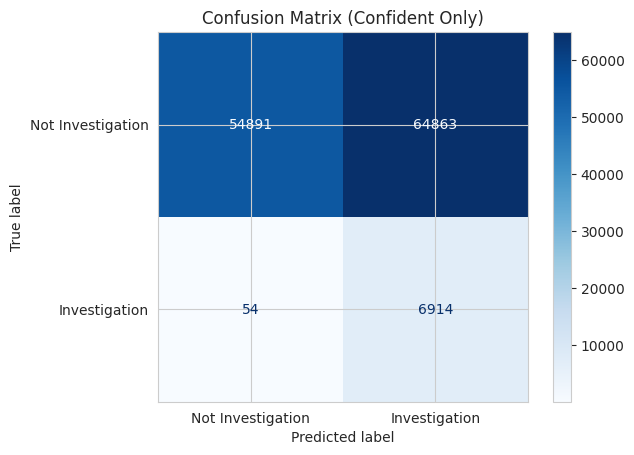

(0.0, 0.01, 0.17560480030478126, 0.99688478421624)

In [220]:
find_best_two_thresholds(
    df_brief,
    metric_name="f1",
    thresholds=np.arange(0, 0.15, 0.01)
)


Лучшие thresholds: low=0.0, high=0.03, roc_auc=0.7253, coverage=99.69%

Classification Report (confident cases):
              precision    recall  f1-score   support

           0       1.00      0.46      0.63    119754
           1       0.10      0.99      0.18      6968

    accuracy                           0.49    126722
   macro avg       0.55      0.73      0.40    126722
weighted avg       0.95      0.49      0.60    126722



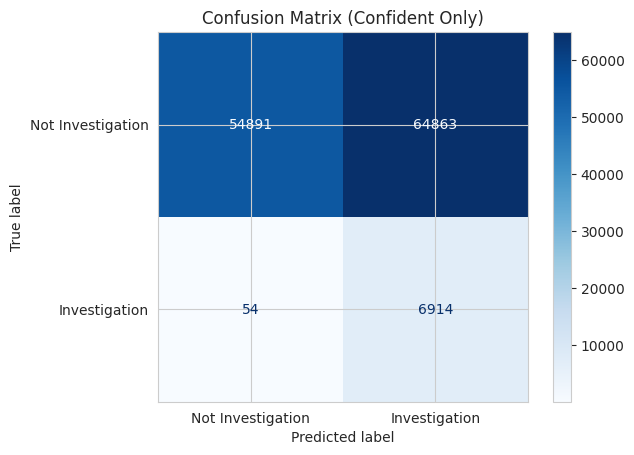

(0.0, 0.03, 0.7253074672769189, 0.99688478421624)

In [221]:
find_best_two_thresholds(
    df_brief,
    metric_name="roc_auc",
    thresholds=np.arange(0, 1.01, 0.03)
)


Лучшие thresholds: low=0.0, high=0.03, precision_1=0.0963, coverage=99.69%

Classification Report (confident cases):
              precision    recall  f1-score   support

           0       1.00      0.46      0.63    119754
           1       0.10      0.99      0.18      6968

    accuracy                           0.49    126722
   macro avg       0.55      0.73      0.40    126722
weighted avg       0.95      0.49      0.60    126722



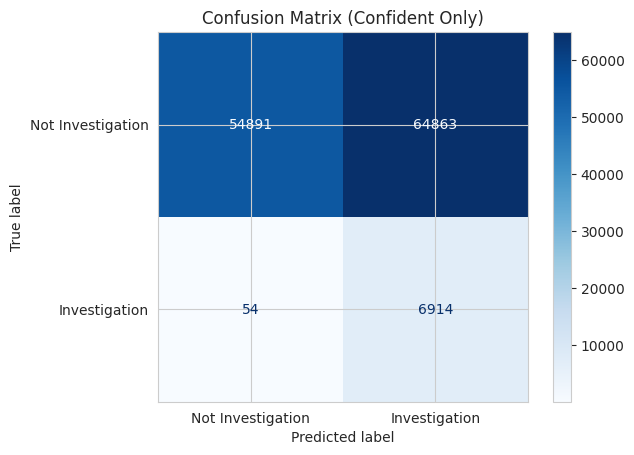

(0.0, 0.03, 0.09632612118087967, 0.99688478421624)

In [222]:
find_best_two_thresholds(
    df_brief,
    metric_name="precision_1",
    thresholds=np.arange(0, 1.01, 0.03)
)

In [194]:
df = df_brief.copy()                     # ← ваш DataFrame
y_true = df["business_status_numeric"].fillna(0).astype(int).tolist()
y_score = df["probability"].fillna(0).astype(int).tolist()

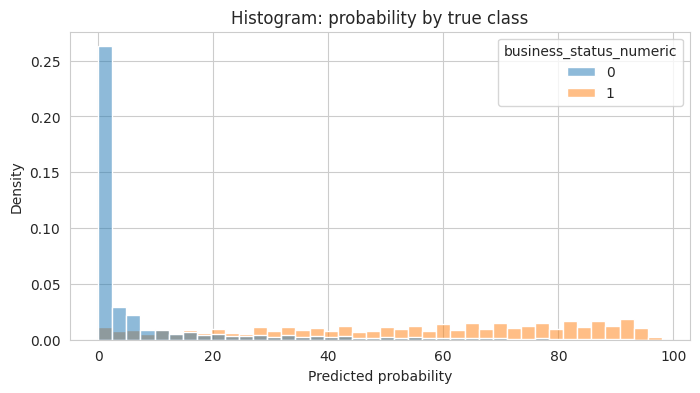

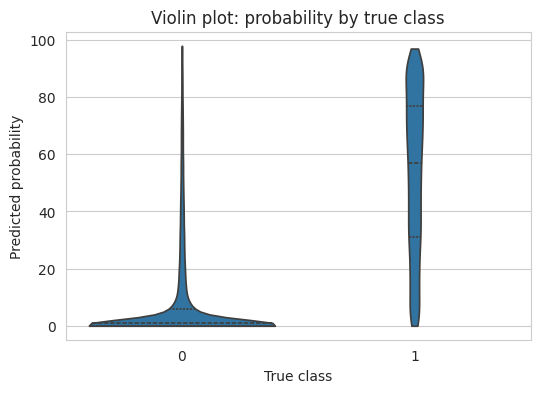

In [195]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x="probability", hue="business_status_numeric",
             bins=40, stat="density", common_norm=False, alpha=0.5)
plt.title("Histogram: probability by true class")
plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.show()

plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="business_status_numeric", y="probability",
               inner="quartile", cut=0)
plt.title("Violin plot: probability by true class")
plt.xlabel("True class")
plt.ylabel("Predicted probability")
plt.show()
sns.set_style("whitegrid")


/home/kdankova/jet_alerts/venv/lib/python3.10/site-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



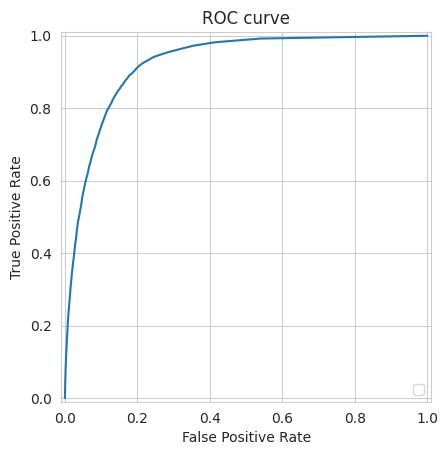

In [200]:
fpr, tpr, _ = roc_curve(y_true, y_score)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("ROC curve")
plt.show()

In [ ]:
best_params = {
     'n_estimators': 838, 
     'max_depth': 10, 
     'learning_rate': 0.021589233059435362, 
     'subsample': 0.6421842567392533, 
     'colsample_bytree': 0.8502585731305644, 
     'gamma': 6.854150277809683, 
     'reg_alpha': 9.970011556918566, 
     'reg_lambda': 2.2875388098900973, 
     'scale_pos_weight': 16, 
     'min_child_weight': 4, 
     'max_delta_step': 7
    }

model = XGBClassifier(**best_params)
model.fit(X_train, y_train)

In [ ]:
# from Karim

async def calculate_metrics_and_save(cls, metric_date, session):
        threshold = 50
        start_dt = datetime.combine(metric_date, datetime.min.time())  # 00:00:00
        end_dt = start_dt + timedelta(days=1)
        stmt = select(
            Incident.create_date_time_utc,
            Incident.probability,
            Incident.business_status
        ).where(
            Incident.create_date_time_utc >= start_dt,
            Incident.create_date_time_utc < end_dt,
            Incident.probability != None
        )
        result = await session.execute(stmt)
        rows = result.all()
        logger.error(f"get results {rows}")
        if not rows:
            print(f"Нет данных для модели xgboost v2 на {metric_date}")
            return

        y_true = [1 if r.business_status else 0 for r in rows]
        y_prob = [r.probability for r in rows]
        y_pred = [int(p >= threshold) for p in y_prob]

        acc = accuracy_score(y_true, y_pred)
        precision_0, precision_1 = precision_score(y_true, y_pred, average=None, zero_division=0)
        recall_0, recall_1 = recall_score(y_true, y_pred, average=None)
        f1 = f1_score(y_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        logger.error("get data")
        try:
            roc_auc = roc_auc_score(y_true, y_prob)
        except ValueError:
            roc_auc = None

        sample_count = len(y_true)
        logger.error("add save")
        metric = MetricsHistory(
            date=metric_date,
            accuracy=acc,
            precision=precision_1,
            precision_neg=precision_0,
            recall=recall_1,
            recall_neg=recall_0,
            f1_score=f1,
            roc_auc=roc_auc,
            sample_count=sample_count,
            created_at=datetime.now(),
            tn=tn,
            tp=tp,
            fp=fp,
            fn=fn,
            fpr=fpr,
        )
        session.add(metric)
        logger.error("save")
        await session.commit()